## 02 Online Learning Model
This notebook builds a machine learning time series forecasting model to predict demand of the Boston Bluebikes bikeshare system. We use an online learning algorithm that is able to analyze incoming data in real time and learn from this future data, improving the future prediction power.

### Notebook Objectives
1. Develop an online learning algorithm to build a ML time series model that can continuously update and learn from incoming data.

In [2]:
from pathlib import Path
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn import base
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import dill

In [3]:
# Load pickled dataframe
counts = pd.read_pickle(Path('./assets/counts_df.pkl'))

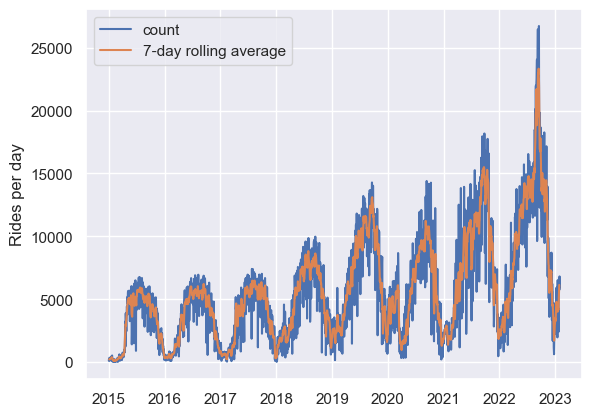

In [4]:
# Plot daily rides
plt.plot(counts, label='count')
plt.plot(counts.rolling(window=7, center=True).mean(), label='7-day rolling average')
plt.ylabel('Rides per day');
plt.legend();

### Online Learning
With most time series data, we want to analyze incoming data in real time and update the machine learning model continuously. Let's build an online learning model that can do just that. We'll start with the custom Transformers developed in the previous notebook.

In [6]:
# Import model developed in previous notebook
with open(Path('./assets/feature_union.dill'), 'rb') as f:
    full_union = dill.load(f)

# Load pickled dataframe of daily trip counts
features = pd.read_pickle(Path('./assets/features_df.pkl'))

In [7]:
# Custom pipeline for online learning (default Pipeline class 
# does not support partial fits)

class PartialFitPipeline(Pipeline):
    
    def partial_fit(self, X, y):
        # Assume transformers without a partial_fit method can be skipped
        Xtrans = X
        for _, step in self.steps[:-1]:
            if hasattr(step, 'partial_fit'):
                step.partial_fit(Xtrans, y)
            Xtrans = step.transform(Xtrans)
        self.steps[-1][1].partial_fit(Xtrans, y)
        return self

sgd_pipe = PartialFitPipeline([('full_union', full_union),
                               ('scaler', StandardScaler()),
                               ('sgd', SGDRegressor(max_iter=1000))])

Let's choose a split point for the initial training window. All data after the split point will be used in the online learning algorithm. At each step, the model will make a prediction about the incoming observation, then train the model with the new observation. Process is then repeated continuously.

In [8]:
split = 1500
features_init = features.iloc[:split]
features_online = features.iloc[split:]

In [9]:
# Let's create two new features: the previous day's count and a five-day rolling average
features_init_df = features_init.copy()
features_init_df['previous'] = features_init['count'].shift(1).fillna(method='bfill')
features_init_df['rolling'] = features_init['count'].ewm(halflife=5).mean().shift(1).fillna(method='bfill')

sgd_pipe.fit(features_init_df, features_init_df['count'])
print(f"Training R^2: {sgd_pipe.score(features_init_df, features_init_df['count'])}")

Training R^2: 0.8814448680835185


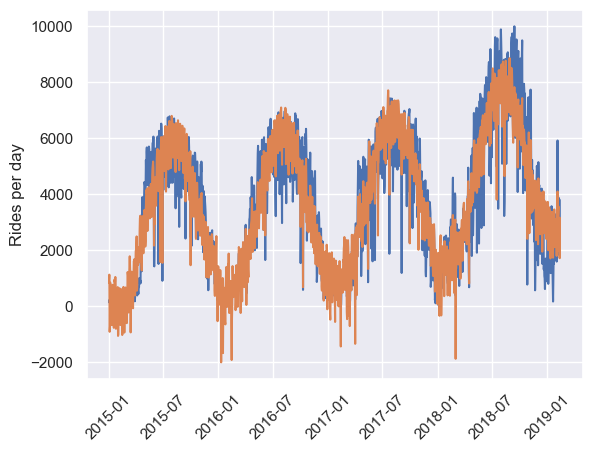

In [10]:
# Visualize fit on initial training window
plt.plot(features_init.index, features_init['count'], label='data')
plt.plot(features_init.index, sgd_pipe.predict(features_init_df), label='model')
plt.xticks(rotation=45);
plt.ylabel('Rides per day');

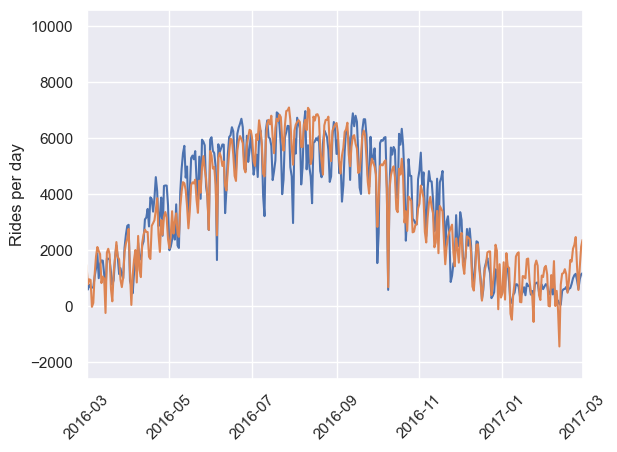

In [11]:
# Zoom in for inspection
plt.plot(features_init.index, features_init['count'], label='data')
plt.plot(features_init.index, sgd_pipe.predict(features_init_df), label='model')
plt.xlim(datetime.date(2016, 3, 1), datetime.date(2017, 3, 1))
plt.xticks(rotation=45);
plt.ylabel('Rides per day');

Now let's step forward through the online learning window. With each step, the model predicts the ride count for that day. The model is then trained on the new count observation and the updated model is used for the next step.

In [12]:
last_count = features_init_df['count'].iloc[-1]
halflife = 5
alpha = 1 - 1./2**halflife
ewm = features_init_df['rolling'].iloc[-1]
last_wind = features_init_df['AWND'].iloc[-1]
last_precip = features_init_df['PRCP'].iloc[-1]
last_snow = features_init_df['SNOW'].iloc[-1]
last_temp = features_init_df['TAVG'].iloc[-1]
predictions = []
coefs = []

for row, values in features_online.iterrows():
    df = pd.DataFrame({'count': values['count'], 'previous': last_count, 'rolling': ewm,
                       'AWND': last_wind, 'PRCP': last_precip, 'SNOW': last_snow,
                       'TAVG': last_temp}, index=[row])
    predictions.append(sgd_pipe.predict(df))
    sgd_pipe.partial_fit(df, df['count'])
    coefs.append(sgd_pipe.named_steps['sgd'].coef_.copy())
    last_count = values['count']
    last_wind = values['AWND']
    last_precip = values['PRCP']
    last_snow = values['SNOW']
    last_temp = values['TAVG']
    ewm = alpha * values['count'] + (1 - alpha) * ewm

print(f"R^2 with online learning: {r2_score(features_online['count'], predictions)}")
sgd_pipe.fit(features_init_df, features_init_df['count'])
print(f"R^2 without online learning: {r2_score(features_online['count'], sgd_pipe.predict(features_online))}")

R^2 with online learning: 0.6502290172648663
R^2 without online learning: 0.4397358815785807


Without online learning, the fixed, stagnant model does quite poorly at predicting rider demand as time progresses in the future.

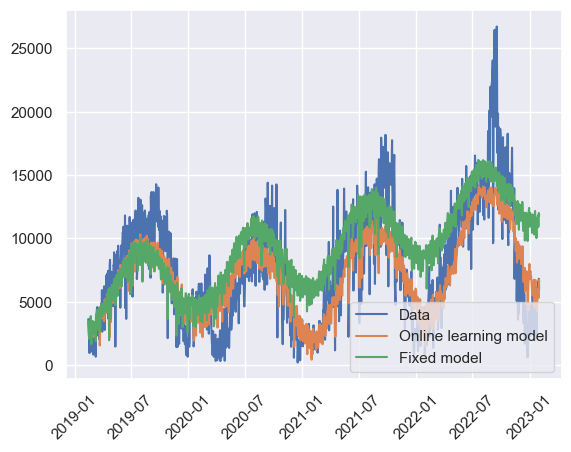

In [13]:
# Visualize fits
plt.plot(features_online.index, features_online['count'], label='Data')
plt.plot(features_online.index, predictions, label='Online learning model')
plt.plot(features_online.index, sgd_pipe.predict(features_online), label='Fixed model')
plt.legend(loc=4)
plt.xticks(rotation=45);

The fixed model clearly starts to drift over time. The online learning model incorporates new data as it comes in and provides a much better fit as time progresses.

Let's see how the $R^2$ changes during each step in the online learning process.

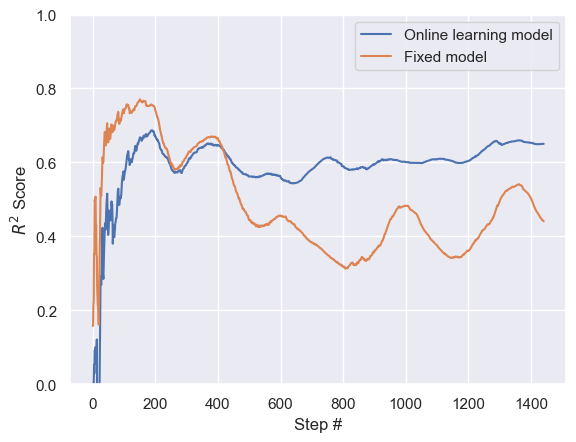

In [14]:
r2 = []
r2_no_online = []
for i in range(5, len(features_online['count'])):
    r2.append(r2_score(features_online['count'][:i], predictions[:i]))
    r2_no_online.append(r2_score(features_online['count'][:i], sgd_pipe.predict(features_online[:i])))

plt.plot(r2, label='Online learning model')
plt.plot(r2_no_online, label='Fixed model')
plt.ylim(0, 1.0)
plt.xlabel('Step #');
plt.ylabel('$R^2$ Score');
plt.legend();

To see how the model is updating over time, let's look at the coefficients.

Last coefficients: [ -202.78309061   942.21023089  -717.28850132 -1101.06772208
    26.51288471   127.81035555   144.2790972    139.66872593
   101.64953217  -226.43122723  -314.16241896  -109.29820869
  -458.53490675    77.26057336   768.25203416]


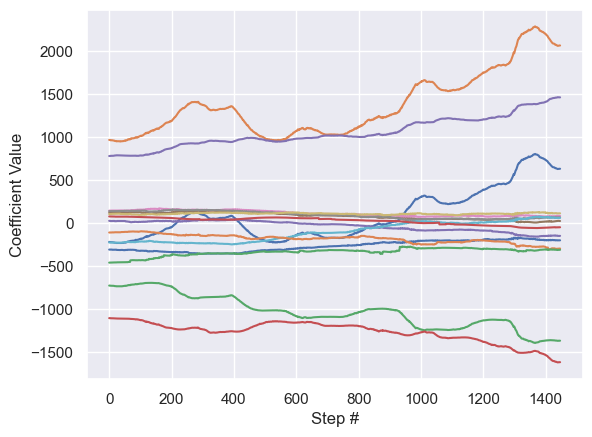

In [15]:
print(f"Last coefficients: {sgd_pipe.named_steps['sgd'].coef_}")

plt.plot(coefs);
plt.xlabel('Step #');
plt.ylabel('Coefficient Value');

It's clear that the model is continuing to learn by adjusting coefficients (weights) as new data comes in.